In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [24]:
df = pd.read_csv('train .csv')

In [25]:
df["TotalSpent"] = df["TotalSpent"].apply(lambda x: "0" if x == " " else x)
df = df.astype({"TotalSpent": "float64"})

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ClientPeriod,5282.0,32.397009,24.550326,0.00,9.0000,29.00,55.0000,72.00
MonthlySpending,5282.0,64.924754,30.176464,18.25,35.4625,70.40,90.0500,118.75
TotalSpent,5282.0,2287.486161,2269.049195,0.00,395.7250,1405.65,3795.2125,8684.80
IsSeniorCitizen,5282.0,0.159409,0.366092,0.00,0.0000,0.00,0.0000,1.00
Churn,5282.0,0.262022,0.439776,0.00,0.0000,0.00,1.0000,1.00


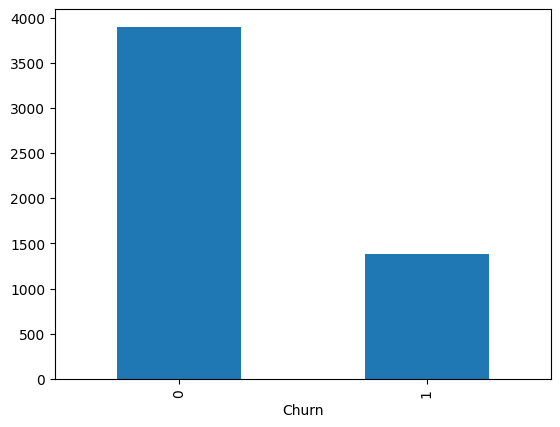

In [28]:
df["Churn"].value_counts().plot(kind="bar");

In [29]:
df["Churn"].value_counts(normalize=True)

Churn
0    0.737978
1    0.262022
Name: proportion, dtype: float64

In [30]:
categorical_cols = [
    'Sex',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod',
]

In [32]:
df = pd.get_dummies(df, columns=categorical_cols)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["Churn"], axis=1),
    df["Churn"],
    test_size=0.2,
    random_state=79,
    shuffle=True,
    stratify=df["Churn"],
)

In [38]:
lr = LogisticRegression(random_state=79, penalty=None, max_iter=10000)

In [39]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, penalty=None, random_state=79)

In [40]:
y_probs = lr.predict_proba(X_test)

In [46]:
[x[0] for x in y_probs]

array([[0.32217711, 0.67782289],
       [0.6082522 , 0.3917478 ],
       [0.49194645, 0.50805355],
       ...,
       [0.73725267, 0.26274733],
       [0.92659805, 0.07340195],
       [0.76870616, 0.23129384]])

In [44]:
roc_auc_score(y_test, y_probs[0])

ValueError: Found input variables with inconsistent numbers of samples: [1057, 2]